# Download library

In [1]:
!pip install transformers==4.28.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.0 MB/s eta 0:00:00


In [2]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 4.0 MB/s eta 0:00:00


In [3]:
!pip install git+https://github.com/huggingface/accelerate

  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-lp_cys23
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-req-build-lp_cys23
  Resolved https://github.com/huggingface/accelerate to commit 420743af22c34a72b19970a97ae829e31285c49e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for accelerate: filename=accelerate-0.24.0.dev0-py3-none-any.whl size=258253 sha256=f0cbab8d64b80da7d245bd7554a54491aa0cd1e4318ebb9ad188d3c2def78564
  Stored in directory: /tmp/pip-ephem-wheel-cache-ombo5shm/wheels/f6/c7/9d/1b8a5ca8353d9307733bc719107acb67acdc95063bba749f26
Successfully built accelerate
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.23.0
    Uninstalling accelerate-0.23.0:
      Successfully uninstalled accelerate-0.23.0


In [4]:
# !pip install huggingface_hub

# Load data and pre-processing

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os

os.environ['CURL_CA_BUNDLE'] = ''

In [7]:
import transformers
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertModel, BertTokenizer
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
import random
from sklearn.utils import shuffle

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm.notebook import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [8]:
train_p = pd.read_csv("/content/drive/MyDrive/data/train_p.csv")
test_p = pd.read_csv('/content/drive/MyDrive/data/test_p.csv')

train_r = pd.read_csv("/content/drive/MyDrive/data/train_r.csv")
test_r = pd.read_csv('/content/drive/MyDrive/data/test_r.csv')

valid_p = pd.read_csv("/content/drive/MyDrive/data/valid_p.csv")
valid_r = pd.read_csv('/content/drive/MyDrive/data/valid_r.csv')

In [9]:
# R_labels=['introduction', 'clarification','workshop management', 'implementation', 'failure']
# Return a list of indices
intro_idx=random.sample(list(train_r.query('label=="introduction"').index), 10)
cl_idx=random.sample(list(train_r.query('label=="clarification"').index),10)
work_idx=random.sample(list(train_r.query('label=="workshop management"').index),10)
imp_idx=random.sample(list(train_r.query('label=="implementation"').index),10)
fail_idx=random.sample(list(train_r.query('label=="failure"').index),10)

# Use indices to select data
train_r = train_r.loc[intro_idx + cl_idx + work_idx+ imp_idx + fail_idx]
# Return a list of indices
info_idx=random.sample(list(train_p.query('label=="information"').index),10)
des_idx=random.sample(list(train_p.query('label=="design action"').index),10)
fa1_idx=random.sample(list(train_p.query('label=="failure action"').index),10)
fa2_idx=random.sample(list(train_p.query('label=="failure reasoning"').index),10)
per_idx=random.sample(list(train_p.query('label=="perception"').index),10)

# Use indices to select data
train_p = train_p.loc[info_idx + des_idx + fa1_idx+ fa2_idx + per_idx]

In [10]:
P_labels=['information','design action', 'failure action','failure reasoning', 'perception']
R_labels=['introduction', 'clarification','workshop management', 'implementation', 'failure']


#Config

In [11]:
# params
bert_lr = 2e-5
max_length=256
epoch = 20
patience = 2
factor = 0.5
# loss function
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = nn.CrossEntropyLoss().to(device)
#batch size
batch_size = 16
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
n_train_r=len(train_r)
n_valid_r=len(valid_r)

n_train_p=len(train_p)
n_valid_p=len(valid_p)


# Model

In [12]:
class TextDataset(Dataset):

    def __init__(self, text, targets, tokenizer):

        self.targets = targets
        self.text = list(text)
        self.tokenizer = tokenizer
        self.encoded_captions = tokenizer(self.text, padding=True, truncation=True, max_length=max_length)

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        item = {
            key: torch.tensor(values[index])
            for key, values in self.encoded_captions.items()
        }

        item['target'] = self.targets[index]

        return item


def create_text_loader(df, shuffle=True):
    ds = TextDataset(text=df['text'].values,
                     targets=df['index'].values,
                     tokenizer=tokenizer)

    return DataLoader(ds,
                      batch_size=batch_size
                      ,shuffle=shuffle)



In [13]:
class Bert(nn.Module):

  def __init__(self, n_classes):
    super(Bert, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-cased')
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask,return_dict=False):
    _, pooled_output = self.bert(input_ids=input_ids,attention_mask=attention_mask, return_dict=False)
    output = self.out(pooled_output)
    return output

In [14]:
import torch
torch.cuda.empty_cache()

In [15]:
def train_epoch(model, train_dataloader, optimizer, scheduler, n_train):
    model = model.train()
    losses = []
    correct_predictions = 0
    process_bar = tqdm(train_dataloader)
    for d in process_bar:
        d = {k: v.to(device) for k, v in d.items() if k != "text"}
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d['target'].to(device)

        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask)

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()
        process_bar.set_postfix(train_loss=loss.item())

    return correct_predictions.double() / n_train, np.mean(losses)

def eval_model(model, val_dataloader, n_valid):
    model = model.eval()

    losses = []
    correct_predictions = 0
    process_bar = tqdm(val_dataloader)
    for d in process_bar:
        d = {k: v.to(device) for k, v in d.items() if k != "text"}
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["target"].to(device)

        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)

        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        process_bar.set_postfix(val_loss=loss.item())

    return correct_predictions.double() / n_valid, np.mean(losses)


def get_predictions(model, test_data_loader):
    model = model.eval()
    predictions = []
    real_values = []

    for d in test_data_loader:
        d = {k: v.to(device) for k, v in d.items() if k != "text"}
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["target"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)

        probs = F.softmax(outputs, dim=1)

        predictions.extend(preds)
        real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return predictions, real_values

In [16]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True')
  plt.xlabel('Predicted')

# Researcher

In [17]:
train_dataloader = create_text_loader(train_r, shuffle=True)
val_dataloader = create_text_loader(valid_r, shuffle=False)
test_dataloader = create_text_loader(test_r, shuffle=False)

In [18]:
model=Bert(5).to(device)
optimizer = AdamW(model.parameters(), lr=bert_lr,correct_bias=False)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=patience, factor=factor)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a 

In [19]:
for e in range(epoch):

  print(f'Epoch {e + 1}/{epoch}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model,
                                      train_dataloader,
                                      optimizer,
                                      scheduler,
                                      n_train_r)
  print(f'Train loss {train_loss} accuracy {train_acc}')
  with torch.no_grad():
      val_acc, val_loss = eval_model(model, val_dataloader, n_valid_r)

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()
  scheduler.step(val_loss)

torch.save(model, '/content/drive/MyDrive/Model/R_10shot_model.pt')

Epoch 1/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.6352477371692657 accuracy 0.24


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.6464921951293945 accuracy 0.11403508771929824

Epoch 2/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.5455005168914795 accuracy 0.32


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.5838901122411093 accuracy 0.16228070175438597

Epoch 3/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.2810271978378296 accuracy 0.46


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.5590254704157511 accuracy 0.3333333333333333

Epoch 4/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.0895738899707794 accuracy 0.72


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.5456172625223796 accuracy 0.3114035087719298

Epoch 5/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.8685831874608994 accuracy 0.84


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.4311805884043376 accuracy 0.42105263157894735

Epoch 6/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.561296857893467 accuracy 0.9400000000000001


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.626133426030477 accuracy 0.43421052631578944

Epoch 7/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.4056805595755577 accuracy 0.96


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.6059957265853881 accuracy 0.3640350877192982

Epoch 8/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.3688834384083748 accuracy 0.9400000000000001


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.6997375249862672 accuracy 0.37280701754385964

Epoch 9/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.1608104519546032 accuracy 1.0


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.7073898712793987 accuracy 0.4122807017543859

Epoch 10/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.0898237731307745 accuracy 1.0


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.7515706936518352 accuracy 0.45175438596491224

Epoch 11/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.06576933711767197 accuracy 1.0


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.8856760581334433 accuracy 0.43859649122807015

Epoch 12/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.03630935354158282 accuracy 1.0


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.9116271336873372 accuracy 0.43859649122807015

Epoch 13/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.030487172305583954 accuracy 1.0


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.901744818687439 accuracy 0.4473684210526315

Epoch 14/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.02273147599771619 accuracy 1.0


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.9104686339696249 accuracy 0.4605263157894737

Epoch 15/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.01889348402619362 accuracy 1.0


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.9147838592529296 accuracy 0.45614035087719296

Epoch 16/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.016077328007668257 accuracy 1.0


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.9181299765904745 accuracy 0.4605263157894737

Epoch 17/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.018073283601552248 accuracy 1.0


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.9238954703013103 accuracy 0.46929824561403505

Epoch 18/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.014384289039298892 accuracy 1.0


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.928476866086324 accuracy 0.46929824561403505

Epoch 19/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.013144600205123425 accuracy 1.0


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.9344035069147745 accuracy 0.46929824561403505

Epoch 20/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.014303843025118113 accuracy 1.0


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.940939982732137 accuracy 0.4605263157894737



In [20]:
with torch.no_grad():
  y_pred, y_test=get_predictions(model, test_dataloader)

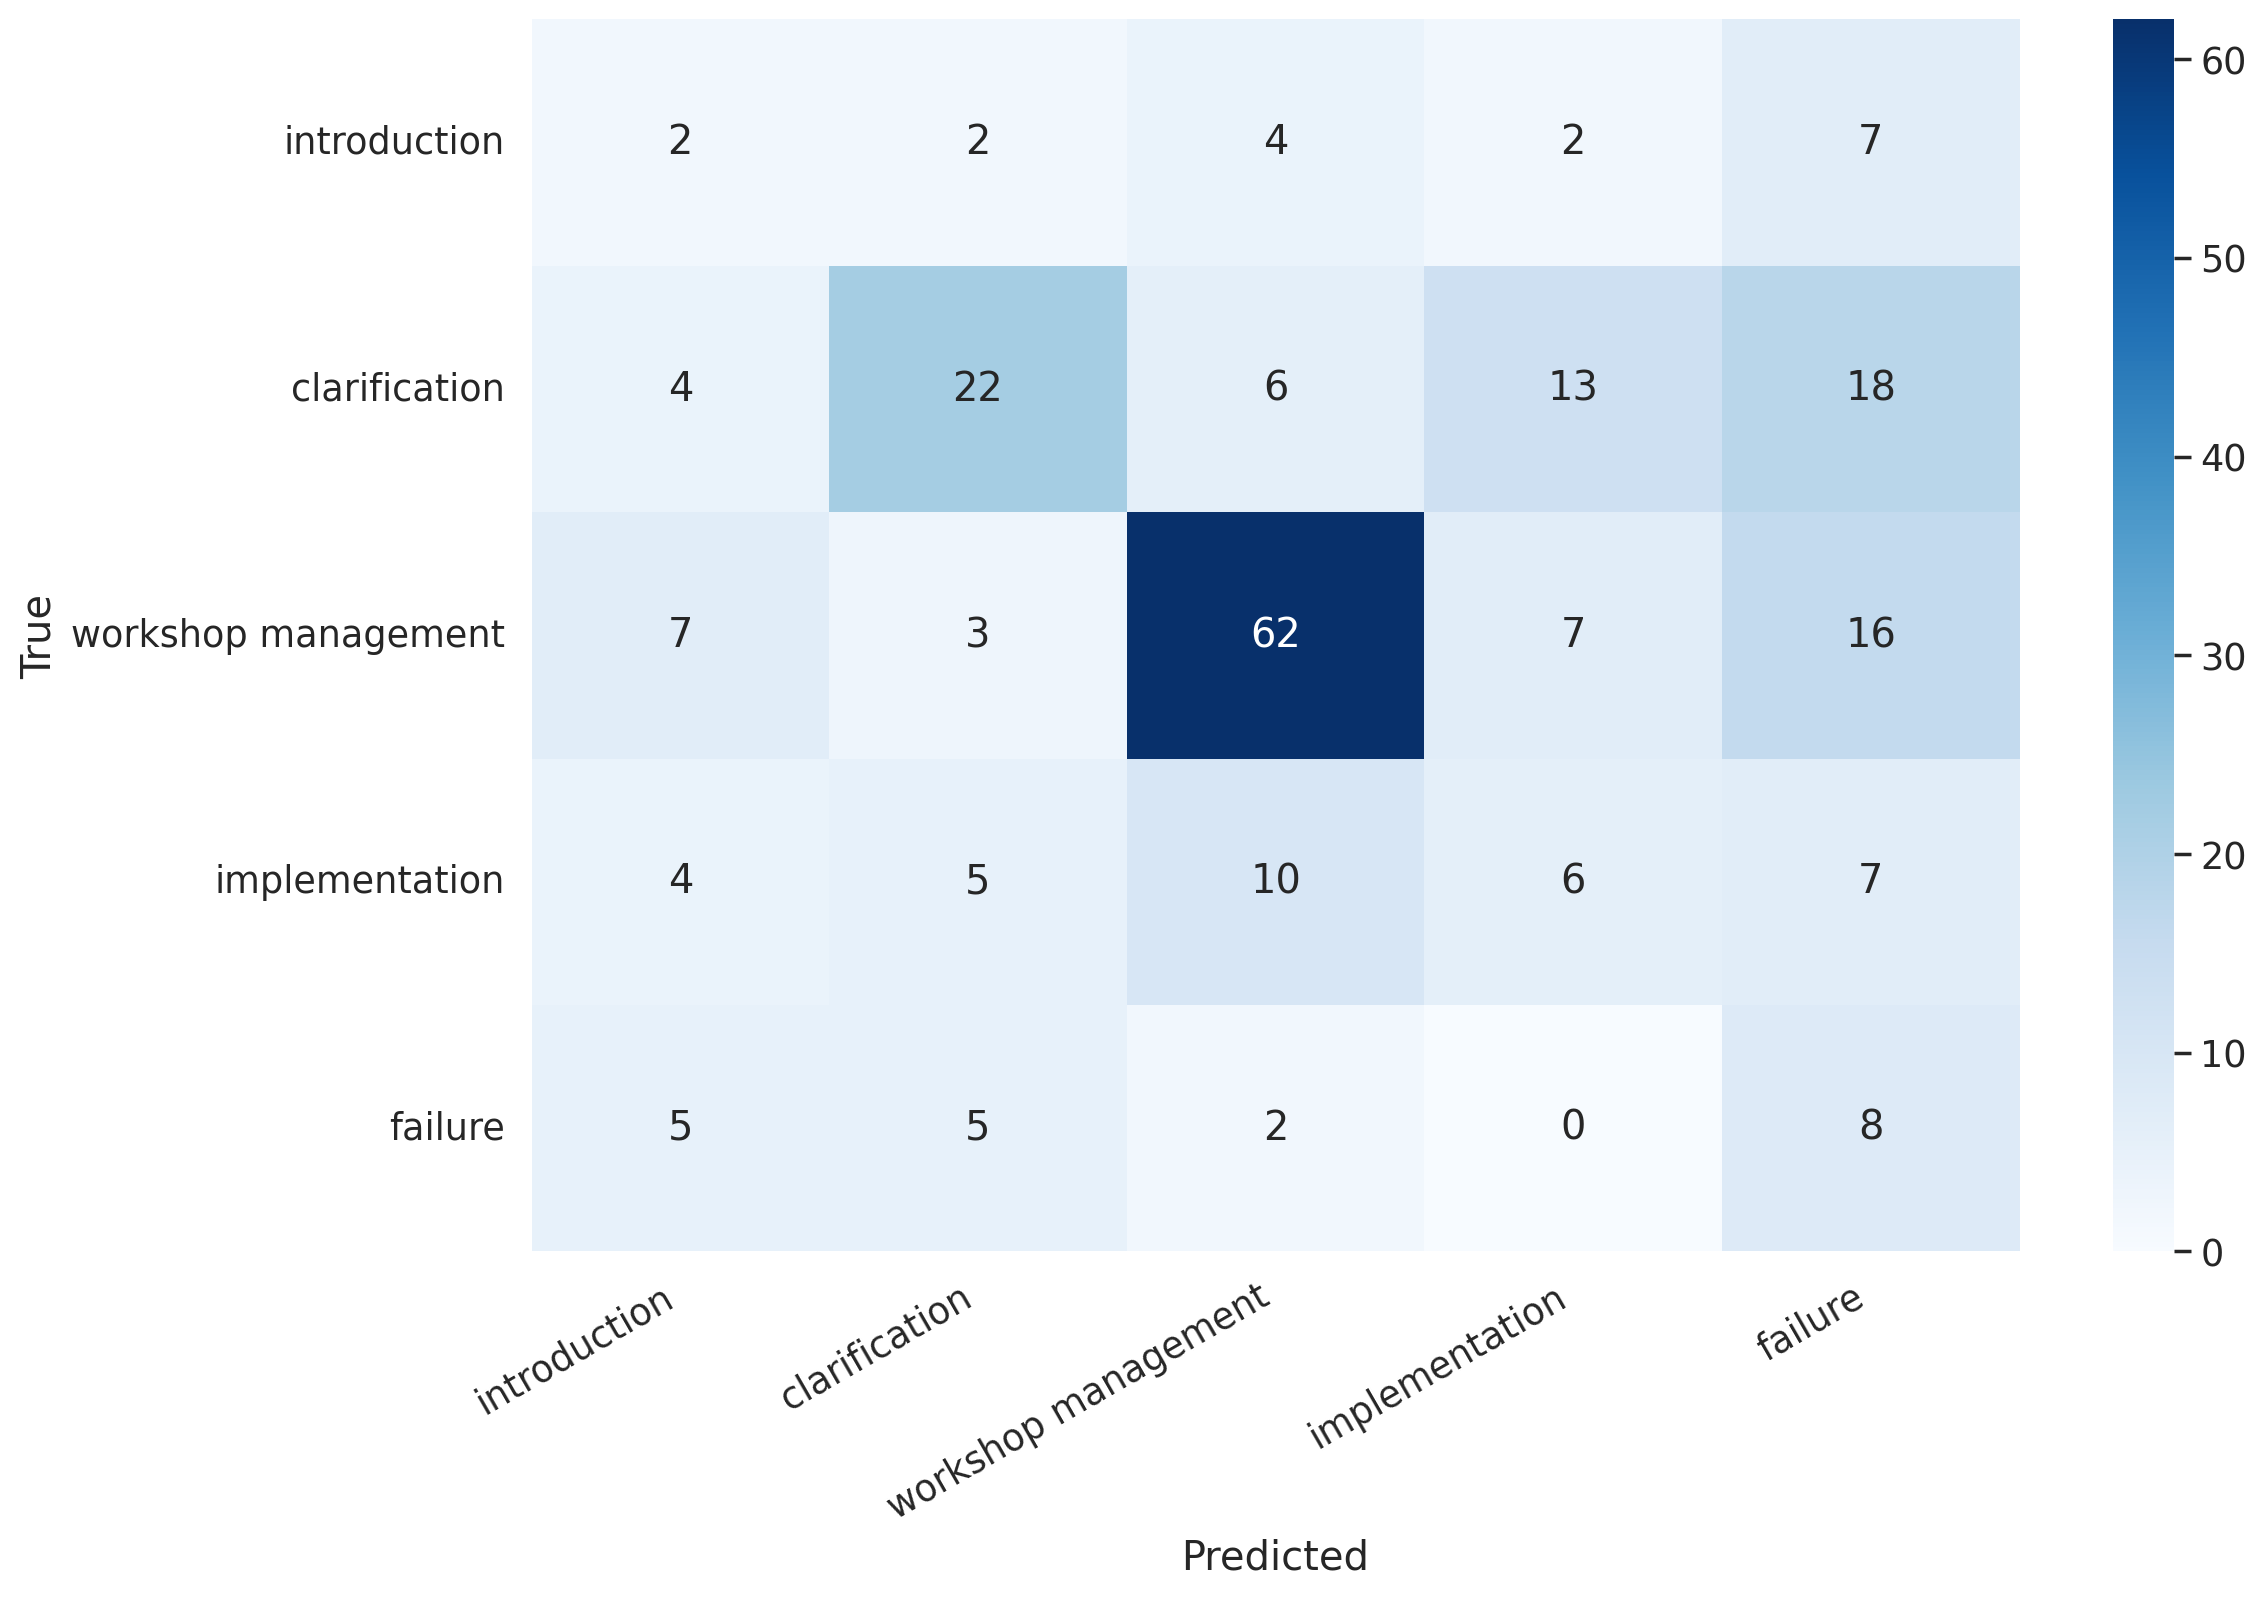

In [21]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=R_labels, columns=R_labels)
show_confusion_matrix(df_cm)

In [22]:
print(classification_report(y_test, y_pred, target_names=R_labels))

                     precision    recall  f1-score   support

       introduction       0.09      0.12      0.10        17
      clarification       0.59      0.35      0.44        63
workshop management       0.74      0.65      0.69        95
     implementation       0.21      0.19      0.20        32
            failure       0.14      0.40      0.21        20

           accuracy                           0.44       227
          macro avg       0.36      0.34      0.33       227
       weighted avg       0.52      0.44      0.47       227



# Participant

In [23]:
train_dataloader_p = create_text_loader(train_p, shuffle=True)
val_dataloader_p = create_text_loader(valid_p, shuffle=False)
test_dataloader_p = create_text_loader(test_p, shuffle=False)

In [24]:
model=Bert(5).to(device)
optimizer = AdamW(model.parameters(), lr=bert_lr,correct_bias=False)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=patience, factor=factor)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a 

In [25]:
for e in range(epoch):

  print(f'Epoch {e + 1}/{epoch}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model,
                                      train_dataloader_p,
                                      optimizer,
                                      scheduler,
                                      n_train_p)
  print(f'Train loss {train_loss} accuracy {train_acc}')
  with torch.no_grad():
      val_acc, val_loss = eval_model(model, val_dataloader_p, n_valid_p)

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()
  scheduler.step(val_loss)

torch.save(model, '/content/drive/MyDrive/Model/P_10shot_model.pt')

Epoch 1/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.6265247464179993 accuracy 0.14


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.5842893918355305 accuracy 0.2692307692307693

Epoch 2/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.4145148992538452 accuracy 0.52


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.6951923271020253 accuracy 0.23626373626373628

Epoch 3/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.2174329161643982 accuracy 0.86


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.5466641783714294 accuracy 0.36813186813186816

Epoch 4/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.8512633442878723 accuracy 0.78


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.7985703746477764 accuracy 0.23076923076923078

Epoch 5/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.5022303909063339 accuracy 1.0


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.8262995978196461 accuracy 0.2802197802197802

Epoch 6/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.23565702512860298 accuracy 1.0


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.9537077446778615 accuracy 0.3296703296703297

Epoch 7/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.16230378299951553 accuracy 1.0


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 2.0626435379187265 accuracy 0.3186813186813187

Epoch 8/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.07619594223797321 accuracy 1.0


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 2.2427875995635986 accuracy 0.2802197802197802

Epoch 9/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.04248899780213833 accuracy 1.0


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 2.3656667272249856 accuracy 0.30219780219780223

Epoch 10/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.0240555377677083 accuracy 1.0


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 2.4534954031308494 accuracy 0.30219780219780223

Epoch 11/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.017933810129761696 accuracy 1.0


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 2.53389240304629 accuracy 0.3131868131868132

Epoch 12/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.014007934834808111 accuracy 1.0


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 2.5999900499979653 accuracy 0.3186813186813187

Epoch 13/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.011339863296598196 accuracy 1.0


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 2.622795601685842 accuracy 0.3076923076923077

Epoch 14/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.0113981356844306 accuracy 1.0


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 2.6374002496401467 accuracy 0.30219780219780223

Epoch 15/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.011171521386131644 accuracy 1.0


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 2.6483895579973855 accuracy 0.2967032967032967

Epoch 16/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.010277200024574995 accuracy 1.0


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 2.6536802450815835 accuracy 0.2967032967032967

Epoch 17/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.0095271454192698 accuracy 1.0


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 2.657532513141632 accuracy 0.2967032967032967

Epoch 18/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.008677871548570693 accuracy 1.0


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 2.6614524324735007 accuracy 0.2967032967032967

Epoch 19/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.009096937719732523 accuracy 1.0


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 2.662819027900696 accuracy 0.2967032967032967

Epoch 20/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.008741533383727074 accuracy 1.0


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 2.665070116519928 accuracy 0.2967032967032967



In [26]:
with torch.no_grad():
  y_pred, y_test=get_predictions(model, test_dataloader_p)

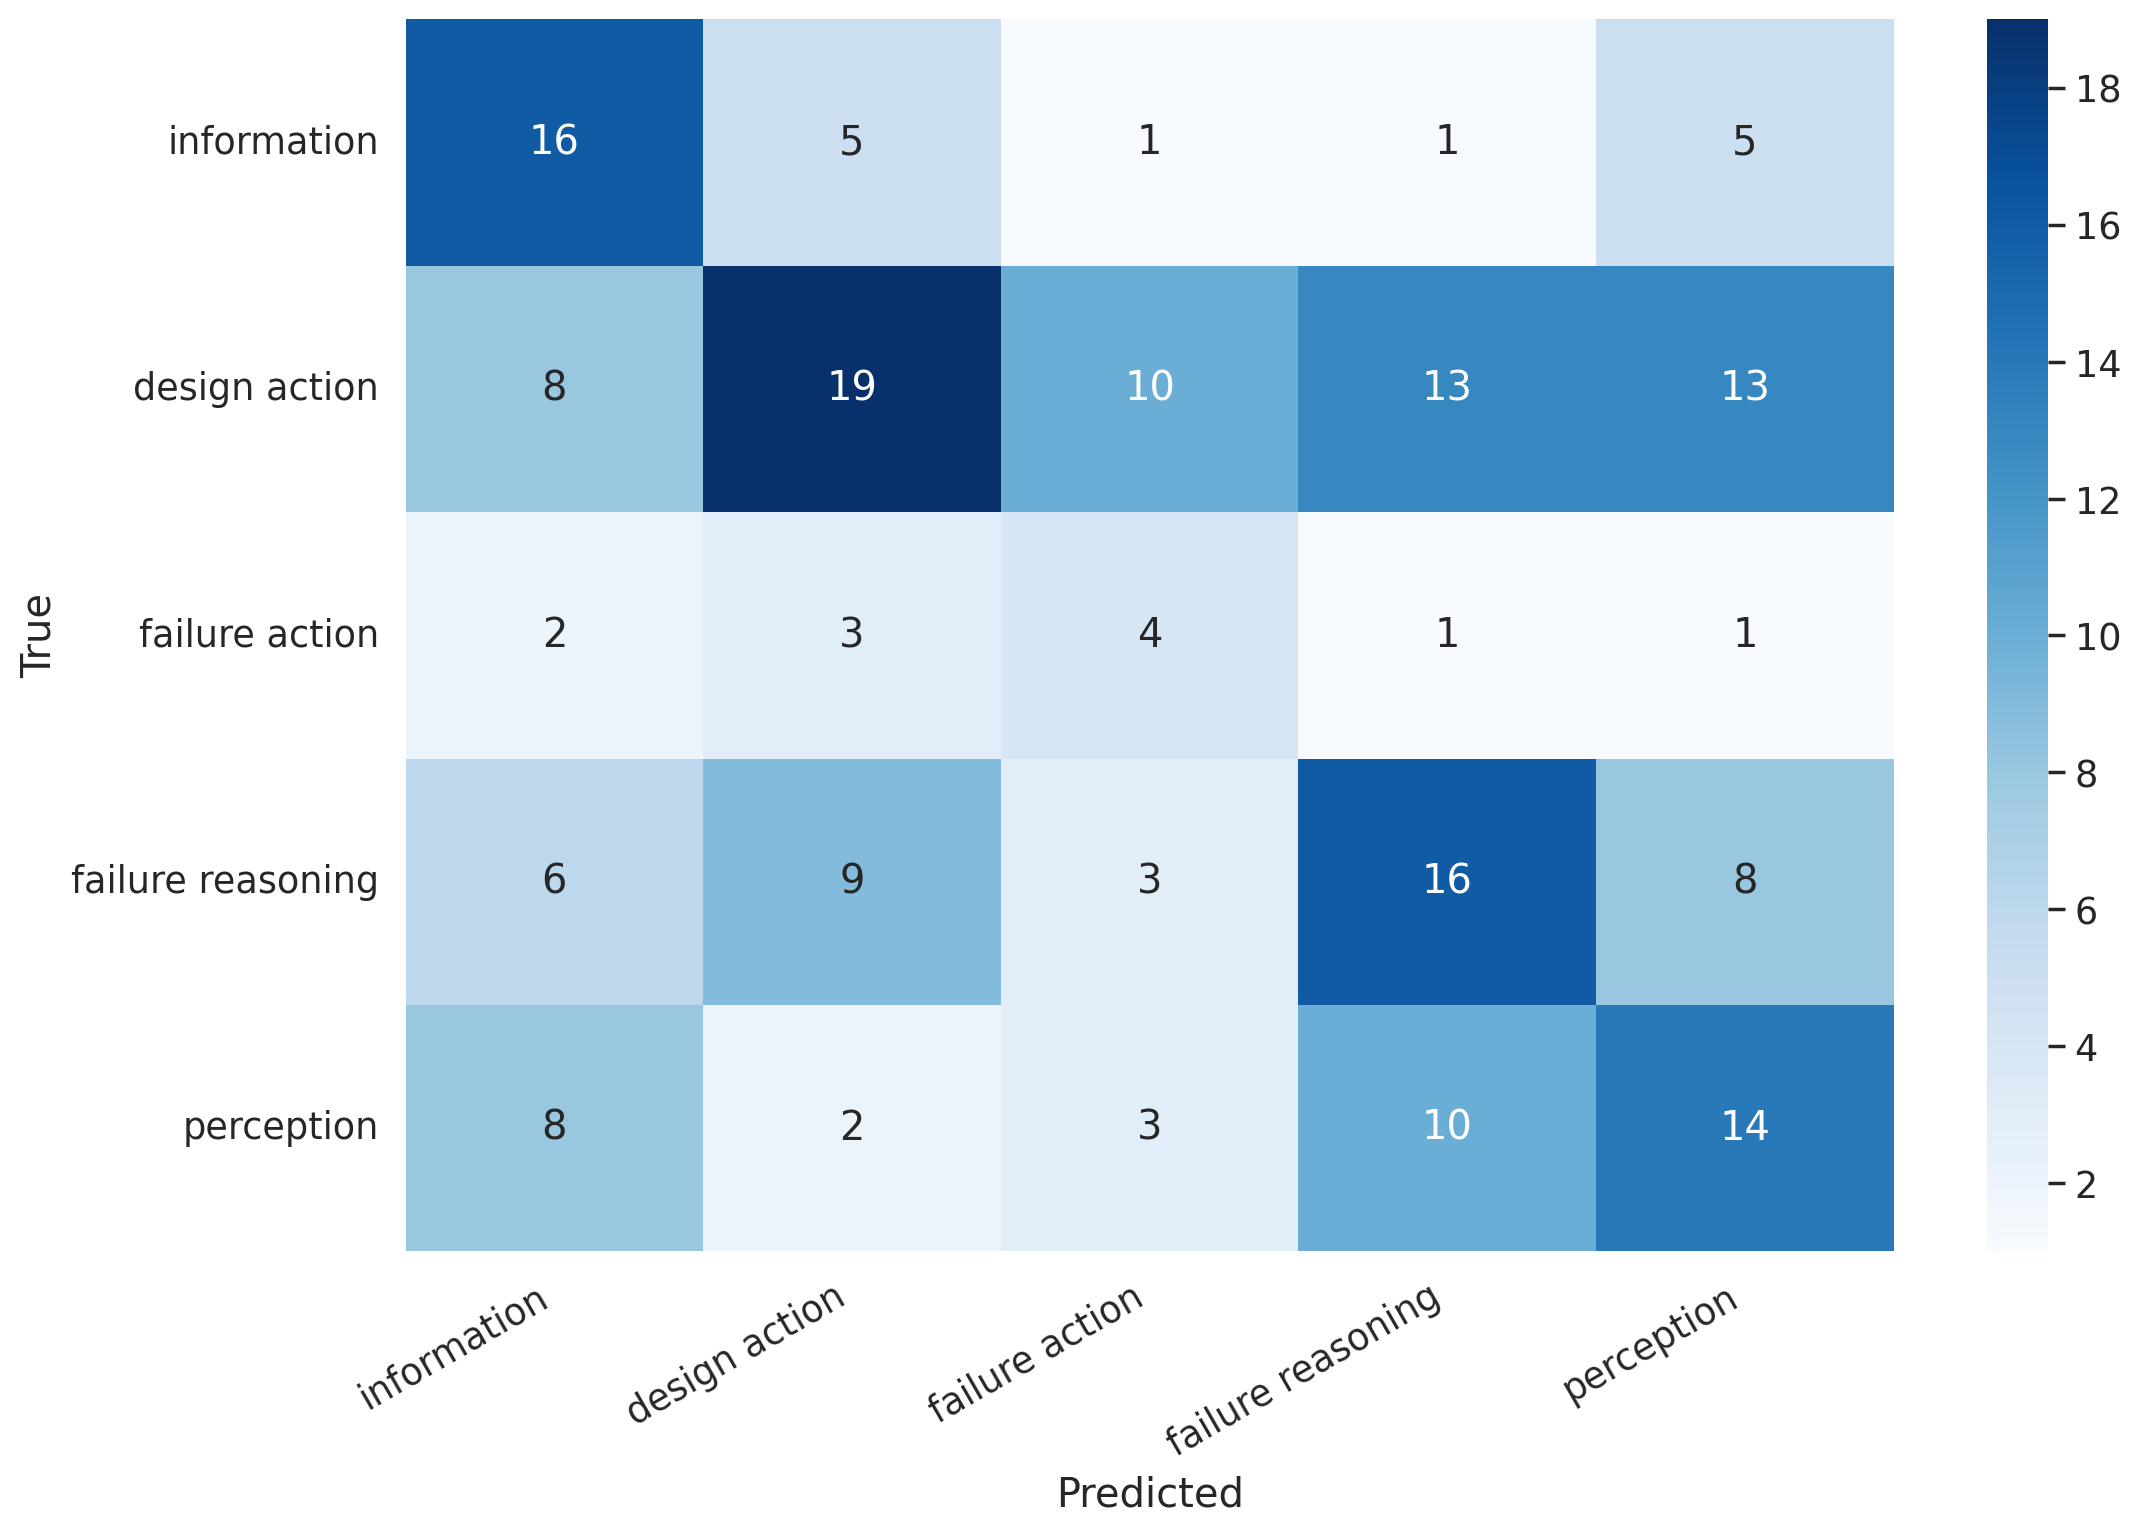

In [28]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=P_labels, columns=P_labels)
show_confusion_matrix(df_cm)

In [29]:
print(classification_report(y_test, y_pred, target_names=P_labels))

                   precision    recall  f1-score   support

      information       0.40      0.57      0.47        28
    design action       0.50      0.30      0.38        63
   failure action       0.19      0.36      0.25        11
failure reasoning       0.39      0.38      0.39        42
       perception       0.34      0.38      0.36        37

         accuracy                           0.38       181
        macro avg       0.36      0.40      0.37       181
     weighted avg       0.41      0.38      0.38       181

